<a href="https://colab.research.google.com/github/leticiabalbi/Projeto-SUPER/blob/main/CBIS2020_Classifica%C3%A7%C3%A3o_de_doen%C3%A7as_respirat%C3%B3rias_em_auscultas_pulmonares_com_crepita%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  
from os import listdir     
import pandas as pd 
import numpy as np
from random import sample
import random
import librosa
from scipy.signal import butter, lfilter, hilbert, chirp
import matplotlib.pyplot as plt
!pip install pyhht
import pyhht
from pyhht import EMD
from pyhht.utils import get_envelops, inst_freq
from numpy import mean, sqrt, square
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, precision_recall_curve

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Carregando a base de dados

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xPucswVV0cBpWCcMNyCahznH6wRe3Oza' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xPucswVV0cBpWCcMNyCahznH6wRe3Oza" -O Respiratory_Sound_Database.tar && rm -rf /tmp/cookies.txt
!tar -C ./ -xvf './Respiratory_Sound_Database.tar'

In [ ]:
files_path = './Respiratory_Sound_Database/audio_and_txt_files/'          #caminho das amostras de áudio e suas anotações
diagnosis_path = './Respiratory_Sound_Database/patient_diagnosis.csv'     #caminho do diagnóstico de cada paciente

# Dataframe das informações necessárias para a realização do experimento

In [ ]:
#Função que retorna o nome de todos os arquivos de uma extensão presentes em um diretório
def files_from_path(path, extension):
  # path: diretório em que se deseja buscar os arquivos 
  # extension: extensão dos arquivos
  files = []
  for file in listdir(path):
    if file.endswith(extension):
      files.append(file)
  return sorted(files)

#Função que retorna um vetor com as informações contidas no nome de uma amostra de áudio
def tokenize_file(filename):
    # filename: nome da amostra de áudio
    return filename.split('_')

In [ ]:
annotations = files_from_path(files_path, ".txt")   
files_ = []

for txt_file in annotations:
    df_annotations = pd.read_csv(files_path + txt_file, sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    txt_file = txt_file[:-4]
    df_annotations['wav_file'] = txt_file + '.wav'
    df_annotations['patient_number'] = tokenize_file(txt_file)[0]
    df_annotations['position'] = tokenize_file(txt_file)[2]
    df_annotations['channel'] = tokenize_file(txt_file)[3]
    df_annotations['device'] = tokenize_file(txt_file)[4]
    files_.append(df_annotations)

df_annotations = pd.concat(files_).reset_index(drop=True)
df_annotations['patient_number'] = df_annotations['patient_number'].astype('float64')

col_names= ['patient_number', 'diagnosis']    
df_diag = pd.read_csv(diagnosis_path, sep=",", header=None, names=col_names)
df_annotations = pd.merge(df_annotations, df_diag, on = 'patient_number')

df_annotations.head(1000)

,start,end,crackles,wheezes,wav_file,patient_number,position,channel,device,diagnosis
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron.wav,101.0,Al,sc,Meditron,URTI
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron.wav,101.0,Al,sc,Meditron,URTI
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron.wav,101.0,Al,sc,Meditron,URTI
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron.wav,101.0,Al,sc,Meditron,URTI
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron.wav,101.0,Al,sc,Meditron,URTI
...,...,...,...,...,...,...,...,...,...,...
995,13.202,15.384,1,0,127_1b1_Ar_sc_Meditron.wav,127.0,Ar,sc,Meditron,Healthy
996,15.384,17.167,0,0,127_1b1_Ar_sc_Meditron.wav,127.0,Ar,sc,Meditron,Healthy
997,17.167,19.421,1,0,127_1b1_Ar_sc_Meditron.wav,127.0,Ar,sc,Meditron,Healthy
998,19.421,19.934,0,0,127_1b1_Ar_sc_Meditron.wav,127.0,Ar,sc,Meditron,Healthy


# Considera amostras que possuem somente a ocorrência de crepitações

In [ ]:
df_annotations = df_annotations[(df_annotations['crackles']==1) & (df_annotations['wheezes']==0)].reset_index(drop=True)

# Formação das classes Crônica, Não crônica e Saudável

In [ ]:
# Classes de doenças presentes na base de amostras que possuem somente a ocorrência de crepitações
np.unique(df_annotations['diagnosis'])

array(['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia',
       'URTI'], dtype=object)



1.   **Chronic**: COPD, Bronchiectasis;
2.   **Non-Chronic**: Bronchiolitis, Pneumonia e URTI;
3.   **Healthy**: Healthy.



In [ ]:
class_ = []
for idx,row in df_annotations.iterrows():
  if row['diagnosis'] == 'COPD' or row['diagnosis'] == 'Bronchiectasis':
    class_.append('Chronic')
  elif row['diagnosis'] == 'Healthy':
    class_.append('Healthy')
  else:
    class_.append('Non-Chronic')

df_annotations['class'] = class_

In [ ]:
# Função que imprime a quantidade de amostras que cada classe possui
def samples_per_class(df):
  print("Chronic: "+ str(len(df.loc[df['class'] == 'Chronic'])))
  print("Non-Chronic: "+ str(len(df.loc[df['class'] == 'Non-Chronic'])))
  print("Healthy: "+ str(len(df.loc[df['class'] == 'Healthy'])))
  print(" ")

In [ ]:
samples_per_class(df_annotations)

Chronic: 1791
Non-Chronic: 57
Healthy: 16
 


# Divisão da base em treino, teste e validação


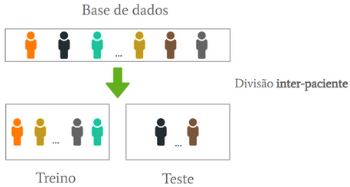

In [ ]:
# O intuito é, que para cada base (treino, teste e validação), a quantidade de pacientes por classe seja proporcional
train_size_per_class = 70             #Treino = 70% dos pacientes de cada classe        
test_size_per_class = 20              #Teste = 20% dos pacientes de cada classe
                                      #Validação = 10% dos pacientes de cada classe

# Para cada classe forma um vetor contendo o id de cada paciente 
patients_Chronic = np.unique(df_annotations.loc[df_annotations['class'] == 'Chronic']['patient_number'])
patients_NonChronic = np.unique(df_annotations.loc[df_annotations['class'] == 'Non-Chronic']['patient_number'])
patients_Healthy = np.unique(df_annotations.loc[df_annotations['class'] == 'Healthy']['patient_number'])

#Embaralha aleatoriamente o vetor do id dos pacientes
random.Random(3).shuffle(patients_Chronic)
random.Random(3).shuffle(patients_NonChronic)
random.Random(3).shuffle(patients_Healthy)

#Define a quantidade de pacientes que cada classe irá ter no treino
train_Chronic = (train_size_per_class*len(patients_Chronic))//100
train_NonChronic = (train_size_per_class*len(patients_NonChronic))//100
train_Healthy = (train_size_per_class*len(patients_Healthy))//100

#Define a quantidade de pacientes que cada classe irá ter no teste
test_Chronic = (test_size_per_class*len(patients_Chronic))//100
test_NonChronic = (test_size_per_class*len(patients_NonChronic))//100
test_Healthy = (test_size_per_class*len(patients_Healthy))//100

#Cria dataframe de treino
df_train = df_annotations.loc[df_annotations['patient_number'] == patients_Chronic[0]]
for i in range(1,train_Chronic):
  df_train = df_train.append(df_annotations.loc[df_annotations['patient_number'] == patients_Chronic[i]])
for i in range(train_NonChronic):
  df_train = df_train.append(df_annotations.loc[df_annotations['patient_number'] == patients_NonChronic[i]])
for i in range(train_Healthy):
  df_train = df_train.append(df_annotations.loc[df_annotations['patient_number'] == patients_Healthy[i]])

#Cria dataframe de teste
df_test = df_annotations.loc[df_annotations['patient_number'] == patients_Chronic[0]]
for i in range(train_Chronic+1,train_Chronic+test_Chronic):
  df_test = df_test.append(df_annotations.loc[df_annotations['patient_number'] == patients_Chronic[i]])
for i in range(train_NonChronic,train_NonChronic+test_NonChronic+1):
  df_test = df_test.append(df_annotations.loc[df_annotations['patient_number'] == patients_NonChronic[i]])
for i in range(train_Healthy,train_Healthy+test_Healthy):
  df_test = df_test.append(df_annotations.loc[df_annotations['patient_number'] == patients_Healthy[i]])

#Cria dataframe de validação
df_val = df_annotations.loc[df_annotations['patient_number'] == patients_Chronic[0]]
for i in range(train_Chronic+test_Chronic+1,len(patients_Chronic)):
  df_val = df_val.append(df_annotations.loc[df_annotations['patient_number'] == patients_Chronic[i]])
for i in range(train_NonChronic+test_NonChronic+1,len(patients_NonChronic)):
  df_val = df_val.append(df_annotations.loc[df_annotations['patient_number'] == patients_NonChronic[i]])
for i in range(train_Healthy+test_Healthy,len(patients_Healthy)):
  df_val = df_val.append(df_annotations.loc[df_annotations['patient_number'] == patients_Healthy[i]])

# Undersampling aleatório da classe Crônica

In [ ]:
samples_per_class(df_train)

Chronic: 1504
Non-Chronic: 43
Healthy: 11
 


In [ ]:
# Função que realiza o undersampling aleatorio de uma determinada classe
def undersampling_class(df,class_,number_of_final_samples):
  #df: dataframe das amostras
  #class_: classe que se deseja realizar o undersampling
  #number_of_final_samples: quantidade de amostras de class_ que se deseja manter no experimento
  idxs = list(df[df['class'] == class_].index)
  out_samples = len(idxs) - number_of_final_samples
  sorted = sample(idxs, out_samples)
  for i in range(len(sorted)):
    df.drop(index=sorted[i], inplace=True)
  df.reset_index(drop=True)

In [ ]:
undersampling_class(df_train, 'Chronic', 50)

In [ ]:
samples_per_class(df_train)

Chronic: 50
Non-Chronic: 43
Healthy: 11
 


# Pré processamento



1.   **Reamostragem de frequência**: as amostras da base apresentam diferentes frequências de amostragem, então é necessário padronizar;
2.   **Segmentação**: segmentação das amostras por ciclos respiratórios (CR) e fases inspiratórias (FI). Consideramos que FI é a metade de um CR;
3.   **Filtragem de ruídos**: tentativa de filtrar sons indesejáveis, tais como batidas do coração e ruídos do ambiente hospitalar;
4.   **Hamming Window**: previne o "vazamento de frequência";
5.   **Normalização**: normalização da amplitude do sinal.



In [ ]:
sr = 4001

In [ ]:
# Filtro Butterworth
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

#Hamming Window
def hamming_window(clip):
    hamming_window = np.hamming(len(clip))
    hamming_windowed_clip = clip * hamming_window
    return hamming_windowed_clip

In [ ]:
# Função de Pré processamento. Retorna um vetor com todas as amostras pré processadas e suas respectivas classes.
def preprocessing(df, path):
  # df: dataframe das amostras que se deseja realizar o pré processamento
  # path: diretorio em que se encontram os áudios .wav
  preprocessed_samples = []
  class_ = []

  for idx,row in df.iterrows():
    filename = row['wav_file']
    start = row['start']
    end = row['end']

    print("Pre processando " + filename + "...")

    #reamostragem e segmentação
    sample_CR = librosa.load(path + filename, sr=sr)[0][int(start*sr) : int(end*sr)]
    sample_FI = sample_CR[0 : int(0.5*len(sample_CR))]
    
    #Filtragem
    sample_CR = butter_bandpass_filter(sample_CR, 120, 1800, fs=sr, order=12)
    sample_FI = butter_bandpass_filter(sample_FI, 120, 1800, fs=sr, order=12)

    #Hamming Window
    sample_CR = hamming_window(sample_CR)
    sample_FI = hamming_window(sample_FI)

    #Normalização
    sample_CR = librosa.util.normalize(sample_CR)
    sample_FI = librosa.util.normalize(sample_FI)

    preprocessed_samples.append(sample_CR)
    class_.append(row['class'])

    preprocessed_samples.append(sample_FI)
    class_.append(row['class'])

  return preprocessed_samples, class_

In [ ]:
x_train, y_train = preprocessing(df_train, files_path)
x_test, y_test = preprocessing(df_test, files_path)
x_val, y_val = preprocessing(df_val, files_path)

# Aumentação de dados na classe Saudável 

In [ ]:
np.unique(y_train,return_counts = True)

(array(['Chronic', 'Healthy', 'Non-Chronic'], dtype='<U11'),
 array([100,  22,  86]))

In [ ]:
#Funcao que realiza a aumentação de dados utilizando a técnica de mudança de tom. Retorna um vetor com 
# as amostras aumentadas e suas respectivas classes
def pitch_shifting(x, y, class_, steps):
  # x: amostras originais
  # y: classes originais
  #class_: classe que se deseja realizar a aumentação de dados
  #steps: vetor com os valores (semitons) para mudar o tom 
  augmented_x = []
  augmented_y = []

  for i in range(len(steps)):
    for j in range(len(y)):
      if y[j] == class_:
        augmented_x.append(librosa.effects.pitch_shift(x[j],sr=sr,n_steps=steps[i]))
        augmented_y.append(y[j])
  
  # Concatena as amostras aumentadas com as amostras originais
  for i in range(len(y)):
    augmented_x.append(x[i])
    augmented_y.append(y[i])

  return augmented_x,augmented_y


In [ ]:
x_train,y_train = pitch_shifting(x_train, y_train, 'Healthy', [-2,-1,1])

In [ ]:
np.unique(y_train,return_counts = True)

(array(['Chronic', 'Healthy', 'Non-Chronic'], dtype='<U11'),
 array([100,  88,  86]))

#### Mais técnicas de aumentação de dados em sinais de áudio: [Clique aqui](https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6)

# Extração de características



1.   Decomposição do Modo Empírico
2.   Extração de 40 características para cada IMF



In [ ]:
# Função de extração de características. Retorna um dataframe com as características extraídas.
def feature_extraction(x,y,n_imfs):
  #x: amostras em que se deseja extrair as características
  #y: classes das amostras em que se deseja extrair as características
  #n_imfs: quantidade de imfs em que se deseja extrair as características
  d = {'class': y}
  df_features = pd.DataFrame(data=d)
  for i in range(len(x)):
    #Decomposição do modo empírico
    imfs = pyhht.emd.EMD(x[i], n_imfs=n_imfs-1).decompose()
    if len(imfs)>= n_imfs:
      for j in range(n_imfs):
        # Extração de 40 características para cada IMF
        rms = sqrt(mean(square(imfs[j])))
        df_features.loc[i, 'imf' + str(j+1) + '_rms'] = rms
        
        upper = get_envelops(imfs[j])[0]
        max_amp = max(upper)
        df_features.loc[i, 'imf' + str(j+1)  + '_max_amp'] = max_amp

        f, t = inst_freq(hilbert(imfs[j]))
        mean_if = mean(f)
        df_features.loc[i, 'imf' + str(j+1)  + '_mean_if'] = mean_if

        spc_centroid = librosa.feature.spectral_centroid(imfs[j], sr=sr)
        std = np.std(spc_centroid)
        df_features.loc[i, 'imf' + str(j+1)  + '_centroid_std'] = std

        var = np.var(spc_centroid)
        df_features.loc[i, 'imf' + str(j+1)  + '_centroid_var'] = var

        minn = np.min(spc_centroid)
        df_features.loc[i, 'imf' + str(j+1)  + '_centroid_min'] = minn

        maxx = np.max(spc_centroid)
        df_features.loc[i, 'imf' + str(j+1)  + '_centroid_max'] = maxx

        med = np.median(spc_centroid)
        df_features.loc[i, 'imf' + str(j+1)  + '_centroid_median'] = med

        meann = np.mean(spc_centroid)
        df_features.loc[i, 'imf' + str(j+1)  + '_centroid_mean'] = meann

        spc_bandwidth = librosa.feature.spectral_bandwidth(imfs[j])
        std = np.std(spc_bandwidth)
        df_features.loc[i, 'imf' + str(j+1)  + '_bandwidth_std'] = std

        var = np.var(spc_bandwidth)
        df_features.loc[i, 'imf' + str(j+1)  + '_bandwidth_var'] = var

        minn = np.min(spc_bandwidth)
        df_features.loc[i, 'imf' + str(j+1)  + '_bandwidth_min'] = minn

        maxx = np.max(spc_bandwidth)
        df_features.loc[i, 'imf' + str(j+1)  + '_bandwidth_max'] = maxx

        med = np.median(spc_bandwidth)
        df_features.loc[i, 'imf' + str(j+1)  + '_bandwidth_median'] = med

        meann = np.mean(spc_bandwidth)
        df_features.loc[i, 'imf' + str(j+1)  + '_bandwidth_mean'] = meann

        spc_flatness = librosa.feature.spectral_flatness(imfs[j])
        std = np.std(spc_flatness)
        df_features.loc[i, 'imf' + str(j+1)  + '_flatness_std'] = std

        var = np.var(spc_flatness)
        df_features.loc[i, 'imf' + str(j+1)  + '_flatness_var'] = var

        minn = np.min(spc_flatness)
        df_features.loc[i, 'imf' + str(j+1)  + '_flatness_min'] = minn

        maxx = np.max(spc_flatness)
        df_features.loc[i, 'imf' + str(j+1)  + '_flatness_max'] = maxx

        med = np.median(spc_flatness)
        df_features.loc[i, 'imf' + str(j+1)  + '_flatness_median'] = med

        meann = np.mean(spc_flatness)
        df_features.loc[i, 'imf' + str(j+1)  + '_flatness_mean'] = meann

        spc_rolloff = librosa.feature.spectral_rolloff(imfs[j], sr=sr)
        std = np.std(spc_rolloff)
        df_features.loc[i, 'imf' + str(j+1)  + '_rolloff_std'] = std

        var = np.var(spc_rolloff)
        df_features.loc[i, 'imf' + str(j+1)  + '_rolloff_var'] = var

        minn = np.min(spc_rolloff)
        df_features.loc[i, 'imf' + str(j+1)  + '_rolloff_min'] = minn

        maxx = np.max(spc_rolloff)
        df_features.loc[i, 'imf' + str(j+1)  + '_rolloff_max'] = maxx

        med = np.median(spc_rolloff)
        df_features.loc[i, 'imf' + str(j+1)  + '_rolloff_median'] = med

        meann = np.mean(spc_rolloff)
        df_features.loc[i, 'imf' + str(j+1)  + '_rolloff_mean'] = meann        

        mfcc = librosa.feature.mfcc(imfs[j], n_mfcc=13, sr=sr)
        mfcc_mean = np.mean(mfcc, axis=1)
        for k in np.arange(len(mfcc)):
          df_features.loc[i, 'imf' + str(j+1)  + '_mfcc_' + str(k)] = mfcc_mean[k]
    else:
      df_features.drop(i, inplace=True)
      print("drop {}".format(str(i)))
  
  return df_features

In [ ]:
# Duração média de execução: 12 minutos
df_train = feature_extraction(x_train,y_train,3)
df_test = feature_extraction(x_test,y_test,3)
df_val = feature_extraction(x_val,y_val,3)

In [ ]:
df_train

,class,imf1_rms,imf1_max_amp,imf1_mean_if,imf1_centroid_std,imf1_centroid_var,imf1_centroid_min,imf1_centroid_max,imf1_centroid_median,imf1_centroid_mean,imf1_bandwidth_std,imf1_bandwidth_var,imf1_bandwidth_min,imf1_bandwidth_max,imf1_bandwidth_median,imf1_bandwidth_mean,imf1_flatness_std,imf1_flatness_var,imf1_flatness_min,imf1_flatness_max,imf1_flatness_median,imf1_flatness_mean,imf1_rolloff_std,imf1_rolloff_var,imf1_rolloff_min,imf1_rolloff_max,imf1_rolloff_median,imf1_rolloff_mean,imf1_mfcc_0,imf1_mfcc_1,imf1_mfcc_2,imf1_mfcc_3,imf1_mfcc_4,imf1_mfcc_5,imf1_mfcc_6,imf1_mfcc_7,imf1_mfcc_8,imf1_mfcc_9,imf1_mfcc_10,imf1_mfcc_11,...,imf3_rms,imf3_max_amp,imf3_mean_if,imf3_centroid_std,imf3_centroid_var,imf3_centroid_min,imf3_centroid_max,imf3_centroid_median,imf3_centroid_mean,imf3_bandwidth_std,imf3_bandwidth_var,imf3_bandwidth_min,imf3_bandwidth_max,imf3_bandwidth_median,imf3_bandwidth_mean,imf3_flatness_std,imf3_flatness_var,imf3_flatness_min,imf3_flatness_max,imf3_flatness_median,imf3_flatness_mean,imf3_rolloff_std,imf3_rolloff_var,imf3_rolloff_min,imf3_rolloff_max,imf3_rolloff_median,imf3_rolloff_mean,imf3_mfcc_0,imf3_mfcc_1,imf3_mfcc_2,imf3_mfcc_3,imf3_mfcc_4,imf3_mfcc_5,imf3_mfcc_6,imf3_mfcc_7,imf3_mfcc_8,imf3_mfcc_9,imf3_mfcc_10,imf3_mfcc_11,imf3_mfcc_12
0,Healthy,0.033958,0.260868,0.278096,82.059006,6733.680446,764.845092,1035.273141,924.425357,912.424876,92.855123,8622.073870,2196.812707,2655.056034,2292.138481,2309.736844,0.040037,0.001603,0.089455,0.287011,0.119922,0.127952,48.309123,2333.771328,1262.034180,1463.256348,1331.387451,1340.466007,-316.801376,26.658685,-57.533398,37.372337,-51.460627,21.548356,-3.229496,2.940757,6.405473,-3.708791,2.313738,-5.399299,...,0.025743,0.289214,0.064393,49.356244,2436.038820,170.528464,343.662135,222.401253,243.999508,160.557494,25778.708884,675.695734,1183.141463,781.780989,867.917680,0.001257,1.579904e-06,0.000079,0.004478,0.000261,0.000980,79.747035,6359.589517,224.665527,513.800293,330.160645,360.671487,-461.720294,199.771143,37.664462,1.567789,-14.097859,-17.957645,-15.595381,-12.668319,-11.155923,-10.068287,-10.983344,-12.815731,-10.229205
1,Healthy,0.041913,0.324504,0.264469,50.476584,2547.885545,770.283341,993.314370,820.187224,833.006642,95.430150,9106.913553,2223.791512,2661.603836,2336.848285,2352.220174,0.037480,0.001405,0.105955,0.238267,0.129159,0.141103,43.460138,1888.783596,1256.173340,1449.581055,1303.060059,1308.461225,-156.140967,47.876986,-63.333663,30.424376,-58.152096,21.138344,-4.488622,4.974640,6.394570,-4.216474,3.029550,-6.484134,...,0.124181,0.855513,0.045936,18.001943,324.069938,142.888878,210.542757,196.482693,189.015962,53.327719,2843.845563,499.578654,702.145141,651.893338,634.123974,0.000038,1.461108e-09,0.000008,0.000138,0.000084,0.000078,26.736755,714.854051,197.314941,300.856445,283.273926,272.356675,-343.063693,218.276739,63.417766,21.990137,-2.805130,-15.615547,-20.421901,-16.219380,-11.711235,-11.695400,-12.575910,-13.341748,-10.904838
2,Healthy,0.040796,0.363656,0.281323,79.406843,6305.446673,726.088448,1037.560253,946.471899,923.949123,68.855860,4741.129511,2163.371877,2401.293324,2298.471859,2285.656860,0.025557,0.000653,0.062125,0.208119,0.110131,0.107850,39.466212,1557.581884,1242.498047,1396.833496,1338.225098,1331.582813,-201.705334,29.243731,-61.147170,42.744515,-55.847133,25.848222,-2.494925,-1.238213,8.697184,-5.703320,1.202705,-2.902703,...,0.047558,0.330554,0.061519,32.281312,1042.083133,161.992571,301.501540,237.838963,240.249324,104.996661,11024.298760,613.437539,1007.520083,817.353279,829.182748,0.000434,1.883161e-07,0.000046,0.001616,0.000366,0.000530,48.641789,2366.023606,230.526367,437.609375,342.859131,353.473763,-371.495607,224.104460,33.585620,5.956167,-17.215996,-19.938265,-16.436240,-13.943238,-11.129672,-8.540363,-9.263866,-11.199791,-9.138873
3,Healthy,0.050995,0.384344,0.271156,85.578386,7323.660092,738.327892,1029.573729,872.672014,885.914659,83.736945,7011.875982,2064.976264,2396.628939,2306.562762,2294.414561,0.

In [ ]:
x_train = np.asarray(df_train[df_train.columns[1:]])
y_train = np.asarray(df_train['class'])

x_test = np.asarray(df_test[df_test.columns[1:]])
y_test = np.asarray(df_test['class'])

x_val = np.asarray(df_val[df_val.columns[1:]])
y_val = np.asarray(df_val['class'])


# Máquina de Vetores de Suporte

In [ ]:
model = SVC(kernel='rbf', C =6)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

confusion = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix: \n{}".format(confusion))

report = classification_report(y_test, y_pred)
print("\nClassification report: \n{}".format(report))


Confusion matrix: 
[[313 176  39]
 [  3   1   0]
 [  1   2  15]]

Classification report: 
              precision    recall  f1-score   support

     Chronic       0.99      0.59      0.74       528
     Healthy       0.01      0.25      0.01         4
 Non-Chronic       0.28      0.83      0.42        18

    accuracy                           0.60       550
   macro avg       0.42      0.56      0.39       550
weighted avg       0.96      0.60      0.72       550

